In [195]:
import pandas as pd
import numpy as np
df = pd.read_csv("../data/processed/export_combined_v1.csv")

/var/folders/zx/63q9k_gd4nb5sbdwq12wb_km0000gn/T/ipykernel_36211/619334726.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/export_combined_v1.csv")


In [196]:
def n_to_nan(x):
    if x == "\\N":
        return np.nan
    return x


def race_time_to_milliseconds(race_time_str):
    """
    Converts a Formula 1 race time string (e.g., "1:20.8888") to milliseconds.

    Parameters:
        race_time_str (str): Race time as a string in the format "M:SS.ssss".

    Returns:
        float: Race time in milliseconds.
    """
    if not isinstance(race_time_str, str):
        return np.nan
    try:
        # Split the string into minutes and seconds
        minutes, seconds = race_time_str.split(":")
        
        # Convert minutes to milliseconds
        minutes_ms = int(minutes) * 60 * 1000
        
        # Convert seconds (with fractional part) to milliseconds
        seconds_ms = float(seconds) * 1000
        
        # Total milliseconds
        total_ms = minutes_ms + seconds_ms
        
        return total_ms
    except Exception as e:
        raise ValueError(f"Invalid race time format: {race_time_str}") from e


In [197]:
def unfuck_data(df):

    df = df.copy()
    # Convert race_date and driver_dob to datetime
    df["race_date"] = pd.to_datetime(df["race_date"])
    df["driver_dob"] = pd.to_datetime(df["driver_dob"])

    # Calculate age in milliseconds
    df["driver_age"] = (df["race_date"] - df["driver_dob"]).dt.total_seconds() * 1000
    df["race_date"] = df["race_date"].astype("int64") // 10**6

    df.drop(
        columns=[
            "resultId",
            "raceId",
            "number",
            "q1_time",
            "q2_time",
            "q3_time",
            "fp1_date",
            "fp1_time",
            "fp2_date",
            "fp2_time",
            "fp3_date",
            "fp3_time",
            "race_time",
            "race_name",
            "quali_time",
            "quali_date",
            "driver_dob",
        ],
        inplace=True,
    )
    df = df.apply(lambda x: x.apply(n_to_nan))

    df["q1"] = df["q1"].apply(race_time_to_milliseconds)
    df["q2"] = df["q2"].apply(race_time_to_milliseconds)
    df["q3"] = df["q3"].apply(race_time_to_milliseconds)
    
    #df["q1"].fillna(0, inplace=True)
    #df["q2"].fillna(0, inplace=True)
    #df["q3"].fillna(0, inplace=True)
    
    df["q2"] = df["q2"].fillna(df["q1"])
    df["q3"] = df["q3"].fillna(df["q2"])
    
    

    from sklearn.preprocessing import LabelEncoder
    labelencoder = LabelEncoder()

    for column in df.columns:
        if df[column].dtype == type(object):
            df[column] = labelencoder.fit_transform(df[column])

    return df

In [198]:
df.head()

,resultId,raceId,driverId,constructorId,number,grid,positionOrder,year,round,circuitId,...,fp2_avg_is_on_fresh_tyres,fp3_avg_sector_1,fp3_avg_sector_2,fp3_avg_lap_time,fp3_avg_speedI1,fp3_avg_speedI2,fp3_avg_speedFL,fp3_avg_speedST,fp3_avg_tyre_life,fp3_avg_is_on_fresh_tyres
0,1,18,1,1,22,1,1,2008,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,18,2,2,3,5,2,2008,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,18,3,3,7,7,3,2008,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,18,4,4,5,11,4,2008,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,18,5,1,23,3,5,2008,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
df = unfuck_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26699 entries, 0 to 26698
Data columns (total 65 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   driverId                     26699 non-null  int64  
 1   constructorId                26699 non-null  int64  
 2   grid                         26699 non-null  int64  
 3   positionOrder                26699 non-null  int64  
 4   year                         26699 non-null  int64  
 5   round                        26699 non-null  int64  
 6   circuitId                    26699 non-null  int64  
 7   race_date                    26699 non-null  int64  
 8   race_location                26699 non-null  int64  
 9   race_country                 26699 non-null  int64  
 10  race_lat                     26699 non-null  float64
 11  race_lng                     26699 non-null  float64
 12  race_alt                     26699 non-null  int64  
 13  q1              

In [200]:
#import matplotlib.pyplot as plt

#for c in df.columns[1:]:
#    df.boxplot(c, by="positionOrder", figsize=(7, 4), fontsize=12)
#    plt.title("{}\n".format(c), fontsize=16)
#    plt.xlabel("positionOrder", fontsize=16)

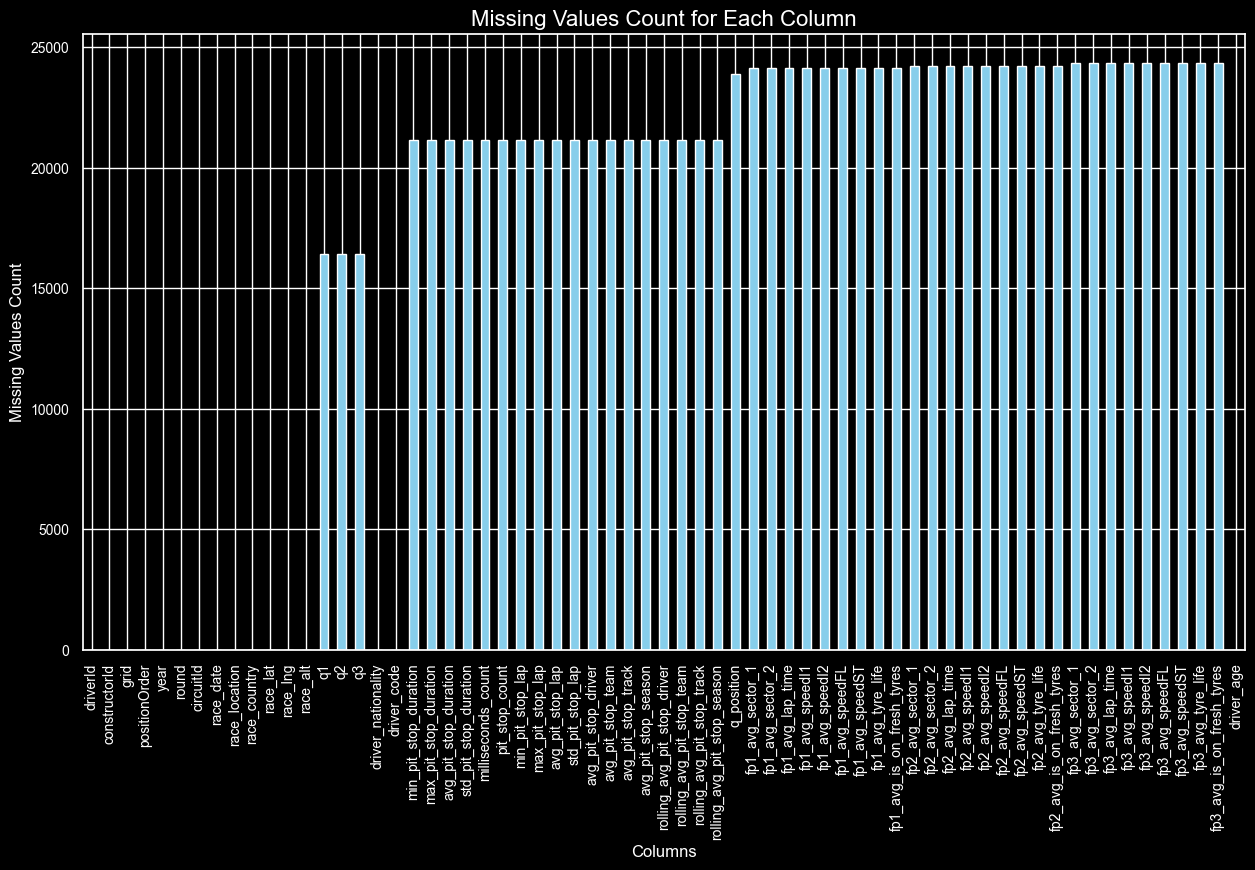

In [201]:
import matplotlib.pyplot as plt

# Count missing values for each column
missing_values = df.isnull().sum()

# Plot the missing values
plt.figure(figsize=(15, 8))
missing_values.plot(kind="bar", color="skyblue")
plt.title("Missing Values Count for Each Column", fontsize=16, color="white")
plt.xlabel("Columns", fontsize=12, color="white")
plt.ylabel("Missing Values Count", fontsize=12, color="white")
plt.xticks(rotation=90, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")
plt.gca().set_facecolor("black")  # Set the background color to black
plt.show()

In [202]:
df = df[df["year"] > 2018]

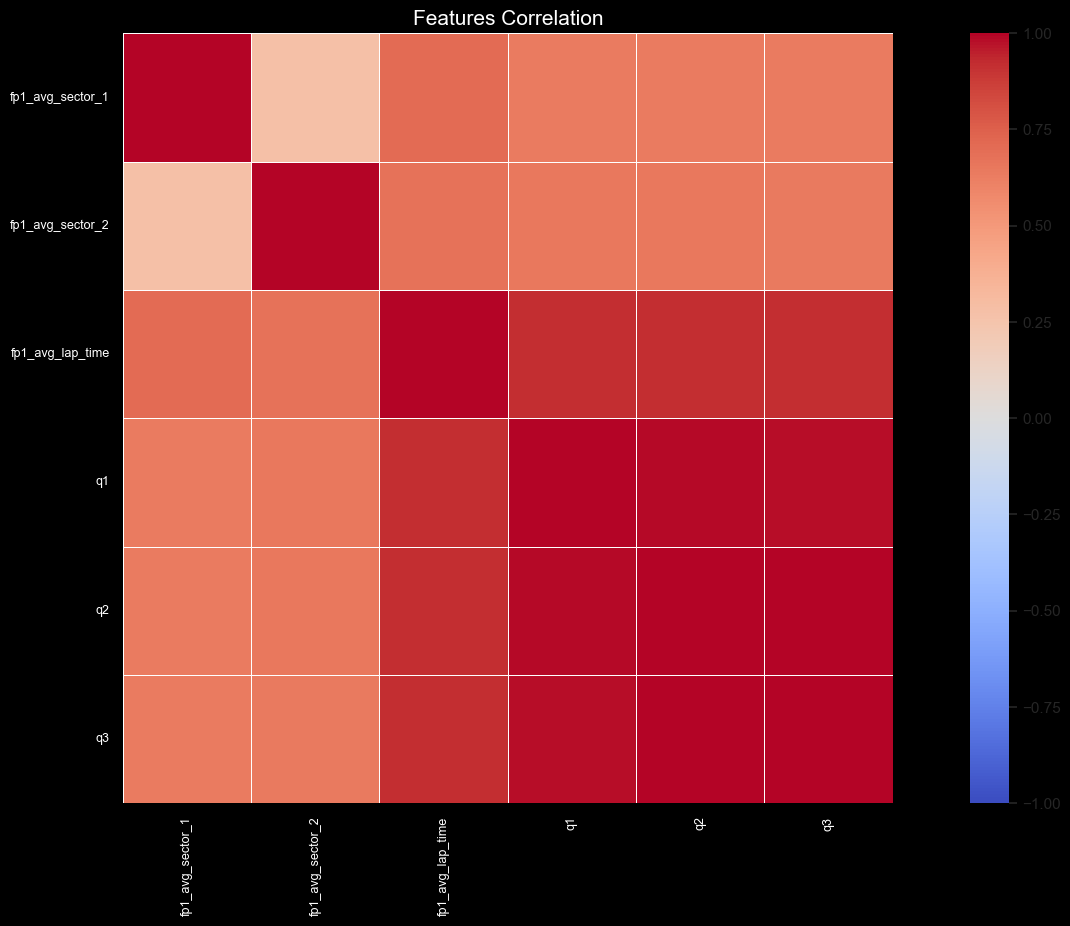

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

def correlation_matrix(df, subset_columns=None):
    plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
    sns.set_theme(
        style="darkgrid",
        palette="coolwarm",
        rc={"axes.facecolor": "black", "figure.facecolor": "black"},
    )

    # If a subset of columns is provided, filter the dataframe
    if subset_columns is not None:
        df = df[subset_columns]

    corr = df.corr()
    sns.heatmap(
        corr,
        annot=False,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        square=True,
        linewidths=0.5,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        vmin=-1,  # Set the minimum value of the color scale
        vmax=1,   # Set the maximum value of the color scale
        annot_kws={"color": "white"}  # Set annotation color to white
    )
    plt.title("Features Correlation", fontsize=15, color="white")
    plt.xticks(rotation=90, fontsize=9, color="white")
    plt.yticks(rotation=0, fontsize=9, color="white")
    plt.show()

# Example usage with a subset of columns
subset = [
    "fp1_avg_sector_1",
    "fp1_avg_sector_2",
    "fp1_avg_lap_time",
    "q1",
    "q2",
    "q3"
]  # Replace with actual column names
correlation_matrix(df, subset)

driverId                     0.089333
constructorId                0.168658
grid                         0.557296
year                        -0.000948
round                        0.000861
                               ...   
fp3_avg_speedFL             -0.001049
fp3_avg_speedST              0.019061
fp3_avg_tyre_life           -0.038164
fp3_avg_is_on_fresh_tyres    0.084859
driver_age                  -0.058896
Name: positionOrder, Length: 64, dtype: float64


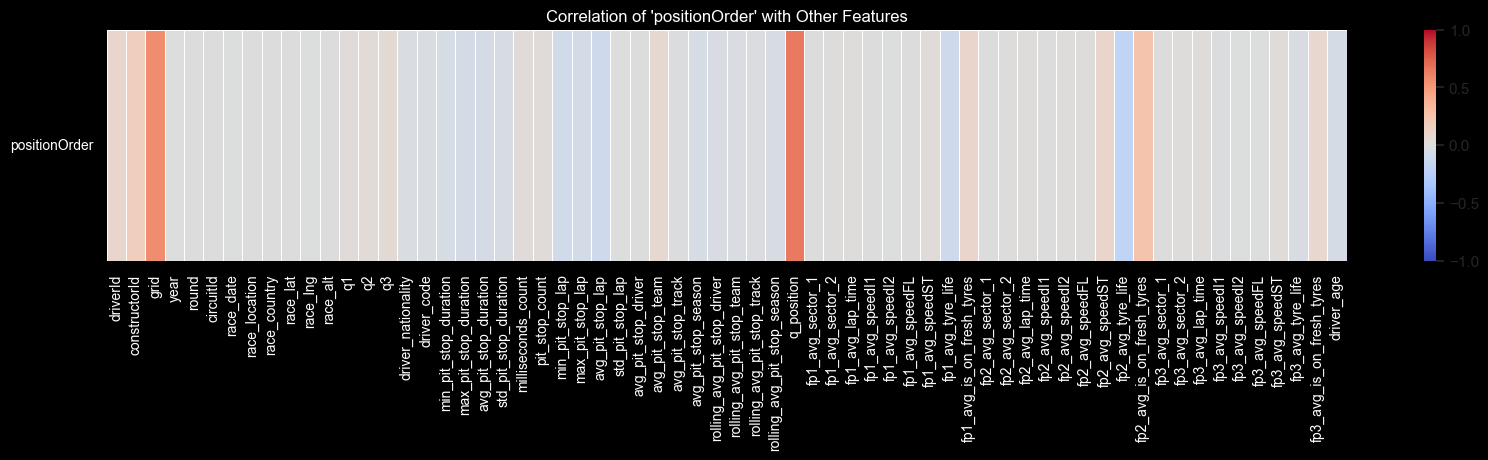

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Extract the correlation of 'positionOrder' with all other features
position_order_corr = corr_matrix["positionOrder"].drop("positionOrder")

# Display the correlations
print(position_order_corr)

# Plot the correlation of 'positionOrder' with all other features as a heatmap
plt.figure(figsize=(20, 3))
sns.heatmap(
    position_order_corr.to_frame().T,
    annot=False,
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    vmin=-1,  # Set the minimum value of the color scale
    vmax=1,
)
plt.title("Correlation of 'positionOrder' with Other Features", color="white")
plt.xticks(rotation=90, fontsize=10, color="white")
plt.yticks(rotation=0, fontsize=10, color="white")
plt.gca().set_facecolor("black")  # Set the background color to black
plt.show()

driverId                     0.063132
constructorId                0.172389
grid                         0.851476
positionOrder                0.643723
year                         0.001195
                               ...   
fp3_avg_speedFL             -0.006860
fp3_avg_speedST              0.017005
fp3_avg_tyre_life           -0.051749
fp3_avg_is_on_fresh_tyres    0.093758
driver_age                  -0.046490
Name: q_position, Length: 64, dtype: float64


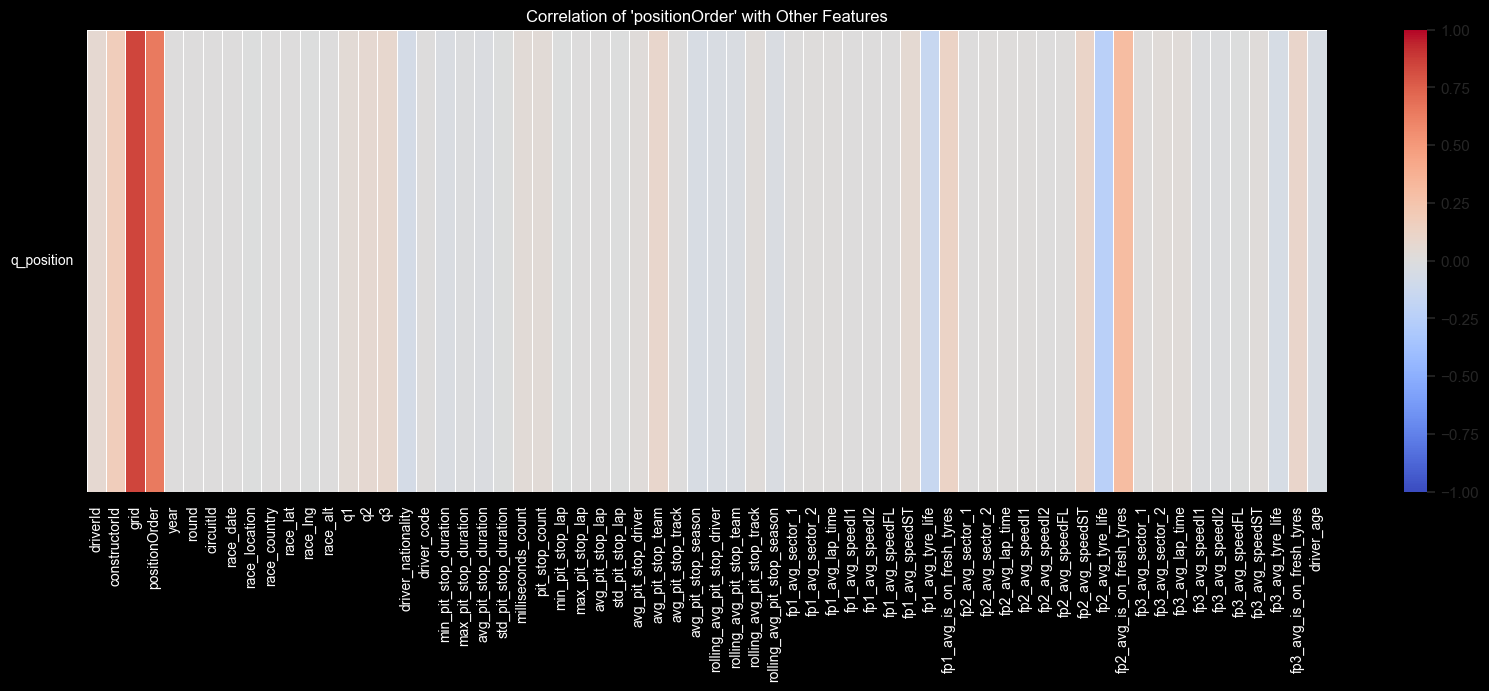

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Extract the correlation of 'positionOrder' with all other features
position_order_corr = corr_matrix["q_position"].drop("q_position")

# Display the correlations
print(position_order_corr)

# Plot the correlation of 'positionOrder' with all other features as a heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(
    position_order_corr.to_frame().T,
    annot=False,
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    vmin=-1,  # Set the minimum value of the color scale
    vmax=1,
)
plt.title("Correlation of 'positionOrder' with Other Features", color="white")
plt.xticks(rotation=90, fontsize=10, color="white")
plt.yticks(rotation=0, fontsize=10, color="white")
plt.gca().set_facecolor("black")  # Set the background color to black
plt.show()

In [206]:
from ydata_profiling import ProfileReport

#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile.to_file("profile_report.html")

## PCA

In [207]:
X_train = unfuck_data(pd.read_csv("../data/train/train.csv"))
y_train = pd.read_csv("../data/train/train_labels.csv")

X_test = unfuck_data(pd.read_csv("../data/test/test.csv"))
y_test = pd.read_csv("../data/test/test_labels.csv")

In [208]:
X_train.shape

(21359, 64)

In [209]:
X_train.dropna(inplace=True)
X_train.shape

(1509, 64)

In [210]:
from sklearn.discriminant_analysis import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [211]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Assuming X_train_scaled is already scaled data from StandardScaler

# Fit PCA
pca = PCA(n_components=None)
dfx_pca = pca.fit(X_train_scaled)

# Retrieve eigenvectors (components/loadings)
eigenvectors = pca.components_  # Shape: (n_components, n_features)

# Retrieve eigenvalues (explained variance)
eigenvalues = pca.explained_variance_



# Explained variance ratio (proportion of variance explained by each component)
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame for loadings
loadings = pd.DataFrame(
    eigenvectors.T,  # Transpose to align features as rows and PCs as columns
    columns=[f"PC{i+1}" for i in range(eigenvectors.shape[0])],
    index=X_train_scaled.columns,  # Assuming columns are the feature names
)

# Display the loadings
print("PCA Loadings (Feature Contributions):")
print(loadings)

# Explained variance
print("\nExplained Variance Ratio:")
print(
    pd.Series(
        explained_variance_ratio,
        index=[f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    )
)

# Most important features for PC1
important_features_pc1 = loadings["PC1"].abs().sort_values(ascending=False)
print("\nMost Important Features for PC1:")
print(important_features_pc1)

PCA Loadings (Feature Contributions):
                                PC1       PC2       PC3       PC4       PC5  \
driverId                  -0.000645  0.028759  0.015441  0.050730  0.042269   
constructorId             -0.012983  0.090455  0.003415  0.060559 -0.063695   
grid                       0.006502  0.014933 -0.002700  0.059880  0.175559   
year                      -0.032391  0.249863  0.024533  0.098818 -0.176784   
round                      0.051895 -0.075367  0.066560  0.206122 -0.140922   
...                             ...       ...       ...       ...       ...   
fp3_avg_speedFL           -0.160190  0.143607  0.056973 -0.287518  0.117526   
fp3_avg_speedST           -0.027745 -0.068904  0.266393 -0.058283  0.060966   
fp3_avg_tyre_life         -0.081798  0.067311 -0.065097  0.055031 -0.150110   
fp3_avg_is_on_fresh_tyres  0.037833 -0.046017 -0.000047 -0.055291  0.048568   
driver_age                -0.005058  0.029191  0.006861 -0.020389 -0.074166   

             

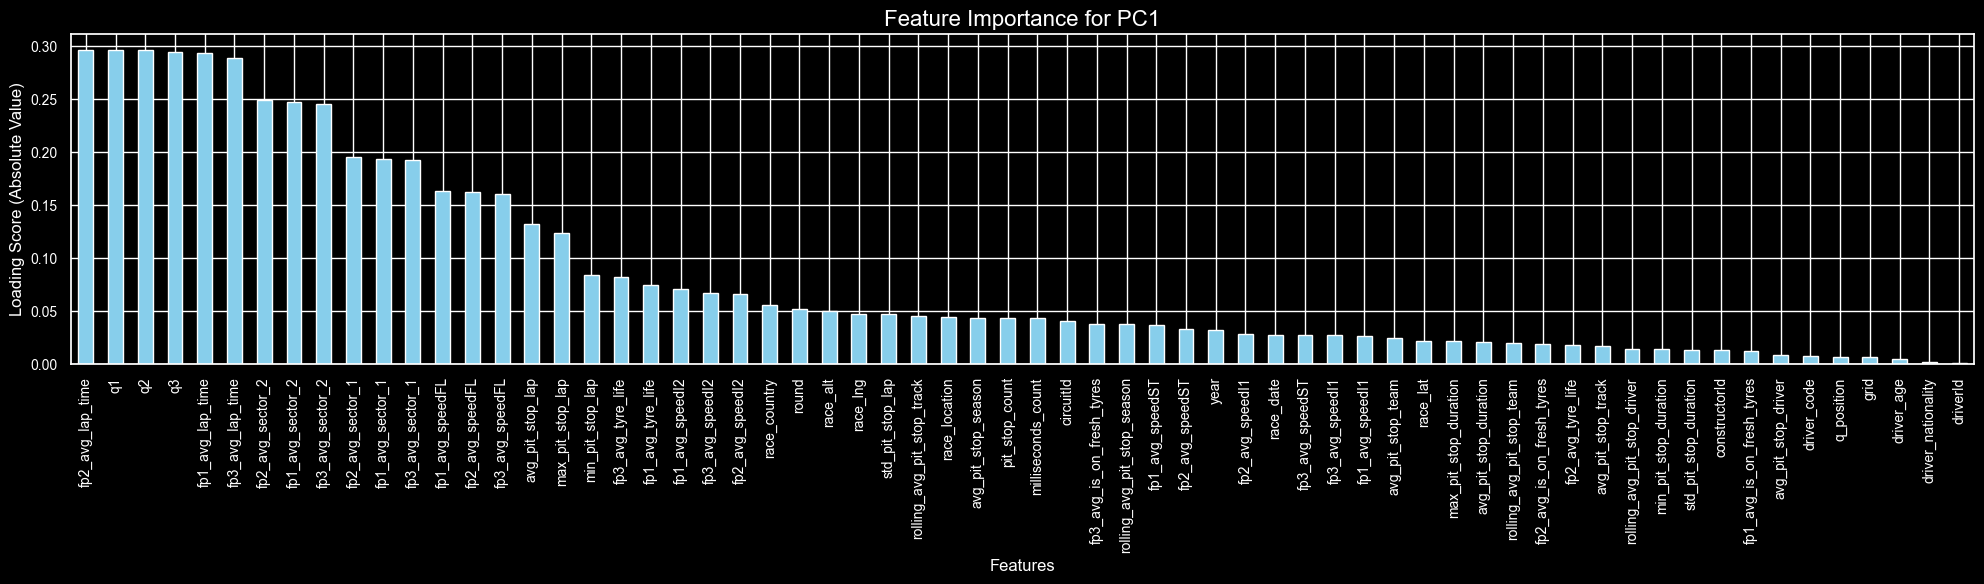

In [212]:
import matplotlib.pyplot as plt

# Bar plot for feature importance in PC1
plt.figure(figsize=(20, 6))
important_features_pc1.plot(kind="bar", color="skyblue")  # Bar color

# Customize the plot
plt.title("Feature Importance for PC1", fontsize=16, color="white")  # Title in white
plt.ylabel(
    "Loading Score (Absolute Value)", fontsize=12, color="white"
)  # Y-axis label in white
plt.xlabel("Features", fontsize=12, color="white")  # X-axis label in white

# Change tick colors to white
plt.xticks(rotation=90, fontsize=10, color="white")  # X-ticks in white
plt.yticks(fontsize=10, color="white")  # Y-ticks in white

# Change background color
plt.gca().set_facecolor("black")  # Axes background color
plt.gcf().set_facecolor("black")  # Figure background color

plt.tight_layout()
plt.show()

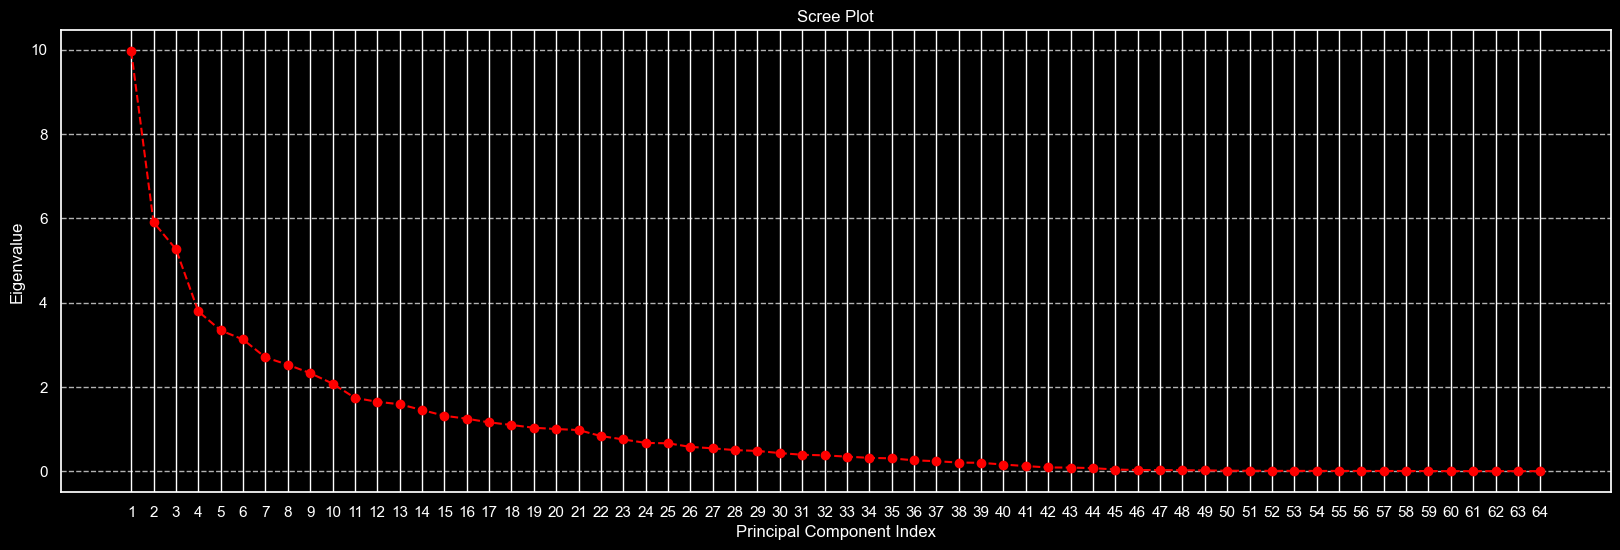

In [221]:
# Scree plot
plt.figure(figsize=(20, 6))
plt.plot(
    range(1, len(eigenvalues) + 1), eigenvalues, marker="o", linestyle="--", color="r"
)
plt.title("Scree Plot", color="white")
plt.xlabel("Principal Component Index", color="white")
plt.ylabel("Eigenvalue", color="white")
plt.xticks(range(1, len(eigenvalues) + 1), color="white")
plt.yticks(color="white")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.gca().set_facecolor("black")  # Set the background color to black
plt.show()

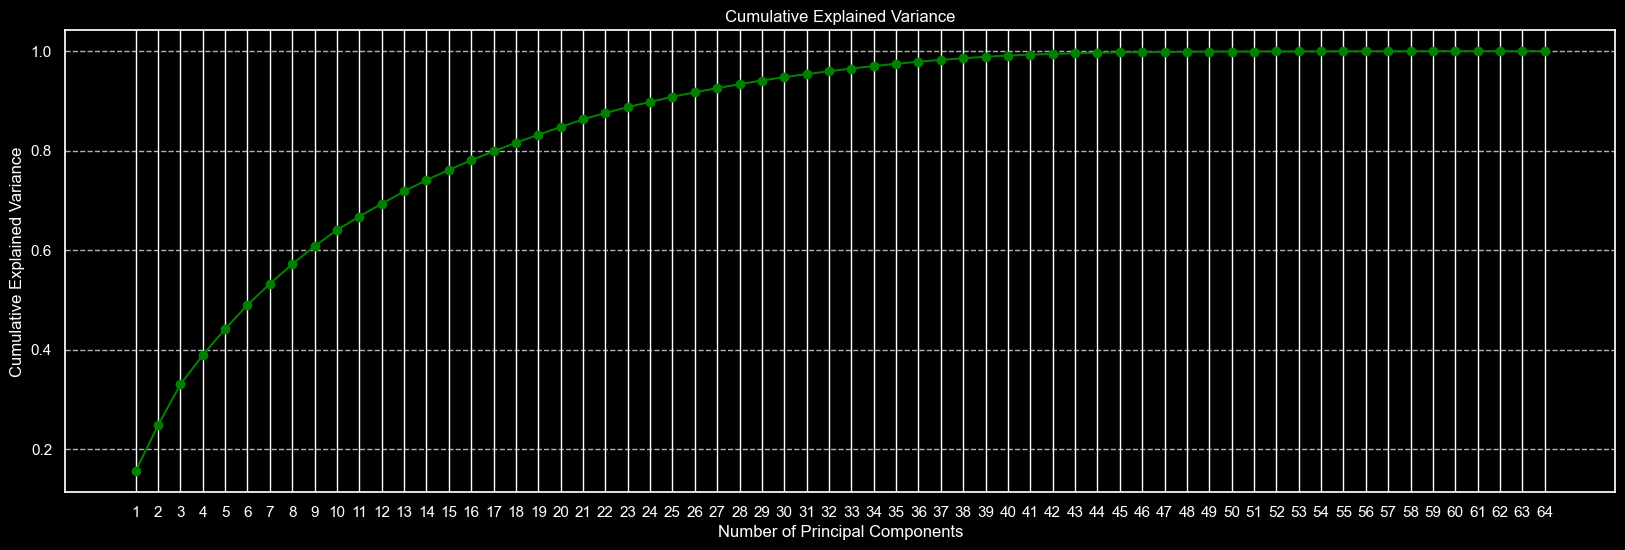

In [214]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(20, 6))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="-",
    color="g",
)
plt.title("Cumulative Explained Variance", color='white')
plt.xlabel("Number of Principal Components", color='white')
plt.ylabel("Cumulative Explained Variance", color='white')
plt.xticks(range(1, len(cumulative_variance) + 1), color='white')
plt.yticks(color='white')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.gca().set_facecolor("black")  # Set the background color to black
plt.show()

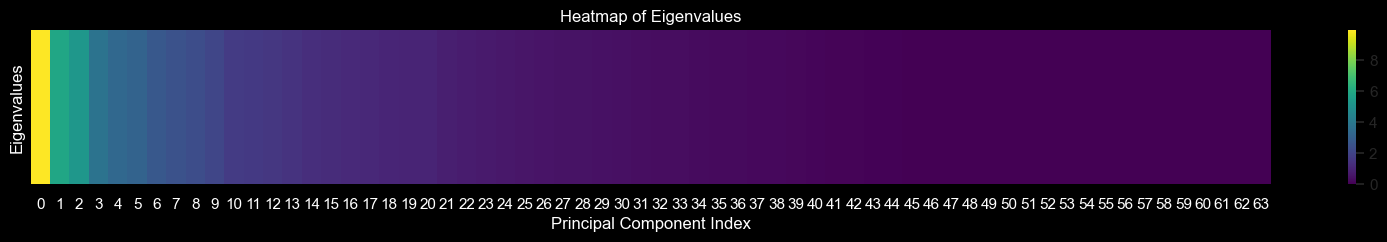

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming eigenvalues is a numpy array
eigenvalues_array = np.array(eigenvalues).reshape(1, -1)  # Reshape into a row vector

# Create a heatmap
plt.figure(figsize=(20, 2))  # Adjust height for a row-like heatmap
sns.heatmap(eigenvalues_array, annot=False, fmt=".2f", cmap="viridis", cbar=True)

# Adding labels and title
plt.title("Heatmap of Eigenvalues", color='white')
plt.xlabel("Principal Component Index", color='white')
plt.ylabel("Eigenvalues", color='white')

# Remove y-axis tick labels for aesthetics
plt.yticks([])

# Change tick colors to white
plt.xticks(color='white')

plt.show()